# <b>CO<sub>2</sub> Trends</b>

### Module Imports



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from urllib.request import urlopen

<br>

### Reading in and Formatting Data

The data from Mauna Loa is provided in a text file. The first 49 lines are just information about it's origin and format, the separator used for the data is one or more blank spaces, and NaN values are given as -999.99.

<a href="https://www.cheatography.com/davechild/cheat-sheets/regular-expressions/">Regular expression overview</a>

In [2]:
## Read in data
col_names = ['year', 'month', 'day', 'dec_date', 'co2_ppm', 'days', '1yr_ago', '10yr_ago', 'change_from_1800']
df_raw = pd.read_csv('co2_weekly_mlo.txt', sep='\s+', skiprows=49, header=None, names=col_names, na_values=-999.99)
df_raw.head()

,year,month,day,dec_date,co2_ppm,days,1yr_ago,10yr_ago,change_from_1800
0,1974,5,19,1974.3795,333.34,6,NaN,NaN,50.36
1,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.06
2,1974,6,2,1974.4178,332.32,5,NaN,NaN,49.57
3,1974,6,9,1974.4370,332.18,7,NaN,NaN,49.63
4,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.07


<br>

Next we'll combine the datetime columns into a single list of datetimes.

Pandas' 'to_datetime()' normally takes something like '2018-12-31' or a list/series in that format, but we can also pass it dictionarys matching each individual datetime component to a series and it will still form the dates.

In [3]:
datetime_dict = {
    'year':df_raw.year, 
    'month':df_raw.month, 
    'day':df_raw.day
}

s_datetimes = pd.to_datetime(datetime_dict)
s_datetimes.head()

0   1974-05-19
1   1974-05-26
2   1974-06-02
3   1974-06-09
4   1974-06-16
dtype: datetime64[ns]

<br>

We can now create a series where the CO2 concentration is the values and the datetime acts as an index. We have to turn the original CO2 series into an array as if we leave it as a series it will try and match with its old index.

In [4]:
s_co2 = pd.Series(data=df_raw['co2_ppm'].values, index=s_datetimes)
s_co2.head()

1974-05-19    333.34
1974-05-26    332.95
1974-06-02    332.32
1974-06-09    332.18
1974-06-16    332.37
dtype: float64

<br>

### Cleaning Data

Before we start analysing the data we need to handle any missing values. 

In [5]:
s_co2.isnull().sum()

20

In [6]:
s_co2[s_co2.isnull()]

1975-10-05   NaN
1975-12-07   NaN
1975-12-14   NaN
1975-12-21   NaN
1975-12-28   NaN
1976-06-27   NaN
1979-05-20   NaN
1982-03-21   NaN
1982-04-11   NaN
1982-04-18   NaN
1983-08-07   NaN
1984-04-01   NaN
1984-04-08   NaN
1984-04-15   NaN
1984-04-22   NaN
1984-12-02   NaN
2005-10-16   NaN
2008-06-29   NaN
2008-07-06   NaN
2008-07-13   NaN
dtype: float64

<br>

When you have missing data that's in a time series format one of the best approaches is to use s.interpolate() which takes the mean of the known values around it.

In [7]:
s = pd.Series([1, np.nan, np.nan, 3])
s

0    1.0
1    NaN
2    NaN
3    3.0
dtype: float64

In [8]:
s.interpolate()

0    1.000000
1    1.666667
2    2.333333
3    3.000000
dtype: float64

In [9]:
s_co2 = s_co2.interpolate()
s_co2.head()

1974-05-19    333.34
1974-05-26    332.95
1974-06-02    332.32
1974-06-09    332.18
1974-06-16    332.37
dtype: float64

<br>

### Visualising the Data

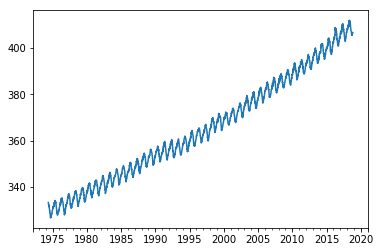

In [10]:
s_co2.plot()

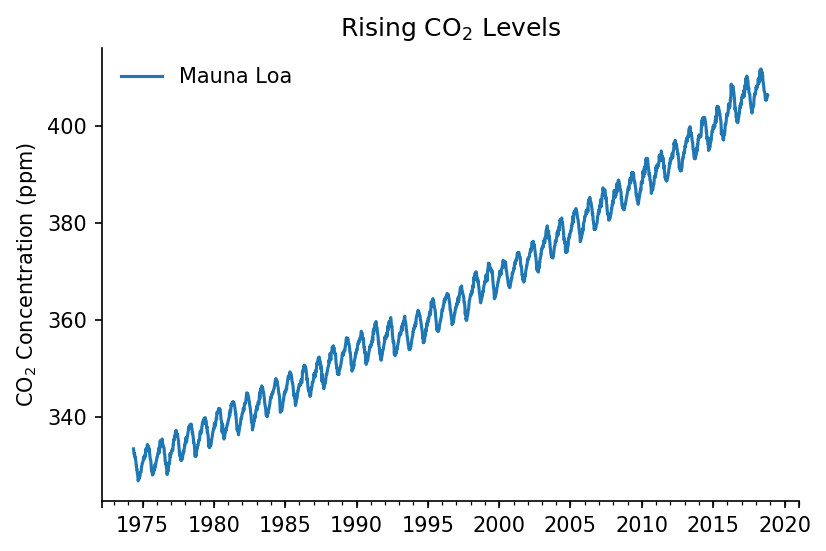

In [11]:
## Creating the figure and defining an axis on it
fig = plt.figure(dpi=150) # dpi refers to the number of pixels (dpi=1080 is equivalent to TV resolution of 1080)
ax = plt.subplot()

## Plotting the data
s_co2.plot(ax=ax, label='Mauna Loa')

## Styling the plot
plt.legend(frameon=False) 
plt.title('Rising CO$_{2}$ Levels') # We can use $ symbols around LaTeX formatted stings to do math formatting 
plt.ylabel('CO$_{2}$ Concentration (ppm)')

ax.spines['right'].set_visible(False) # Here we remove the top and right axis spines
ax.spines['top'].set_visible(False)

<br>

### Stationarity

A common assumption in many time series techniques is that the data is stationary, this means the mean, variance and autocorrelation of the series does not change over time.

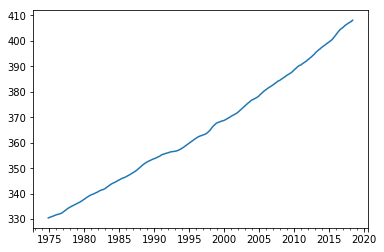

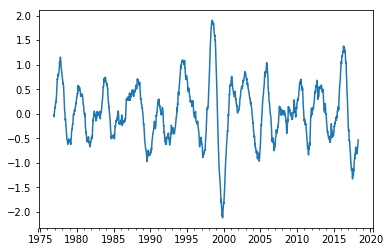

In [12]:
year = 52

plt.figure()
s_co2_annual_mean = s_co2.rolling(window=year, center=True).mean()
s_co2_annual_mean.plot()

plt.figure()
s_co2_annual_delta = s_co2_annual_mean - s_co2_annual_mean.shift(year)
s_co2_annual_autocorr = s_co2_annual_delta - s_co2_annual_delta.shift(year) # Bit like second derivative
s_co2_annual_autocorr.plot()

We can see that the mean does have a strong upwards trend, the autocorrelation of the series appears constant over time.

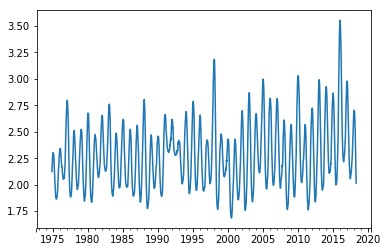

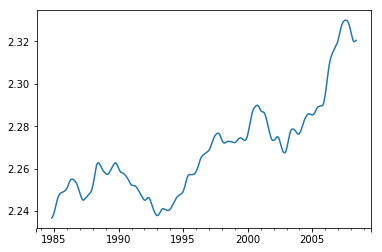

In [13]:
plt.figure()
s_co2_annual_std = s_co2.rolling(window=year, center=True).std()
s_co2_annual_std.plot()

plt.figure()
s_co2_annual_std_trend = s_co2_annual_std.rolling(window=year*20, center=True).mean()
s_co2_annual_std_pct_trend = 100 * s_co2_annual_std_trend/s_co2_annual_std
s_co2_annual_std_trend.plot()

The standard deviation appears fairly stationary but there is a small upwards trend.

<br>

We can more rigorously check for stationarity, here we use an augmented Dickey-Fuller test which determines how likely the series is stationary. The Statsmodels module contains this as well as other unit root tests.

if the P-value is less than 0.05 we'll accept the alternative hypothesis that the data is stationary, if it is above we accept the null hypothesis that the series is non-stationary. If you want to learn more check out <a href="https://www.youtube.com/watch?v=wPBlWDQ-vPk">this youtube video</a>.

In [14]:
adfuller(s_co2, maxlag=52, autolag=None)

(6.53401698368656,
 1.0,
 52,
 2267,
 {'1%': -3.43323783412235,
  '5%': -2.862815772147102,
  '10%': -2.5674491526610006})

In [15]:
adf_test = adfuller(s_co2, maxlag=52)
p_value = adf_test[1] 

Here the test strongly indicates that the series is non-stationary.

<br>

### Seasonal Decomposition

We can use additive linear models to decompose time series. In this model we can make one from three components: Trend + Seasonality + Noise

For example, for monthly data, an additive model assumes that the difference between the January and July values is approximately the same each year.

<Figure size 432x288 with 0 Axes>

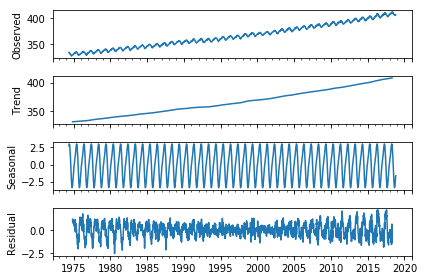

In [16]:
## Decompose the timeseries
result = seasonal_decompose(s_co2, model='additive')

## Plotting
plt.figure()
result.plot()
plt.show()

<br> 

### Difference Models

We can manually construct the difference models

First Difference P-value: 7.815305390526735e-22
Annual Difference P-value: 3.3068145855713134e-08
Annual Difference on First Difference P-value: 1.3410855329781781e-08


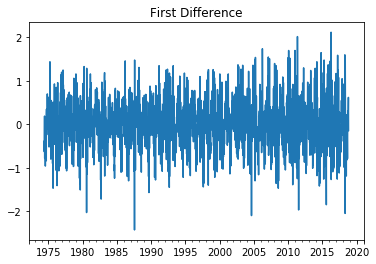

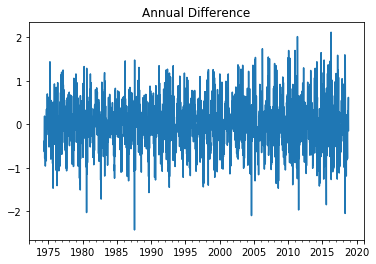

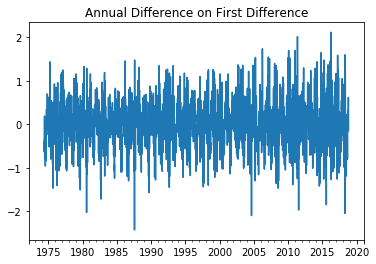

In [17]:
def difference_test_and_plotter(s_co2, difference):
    ## Difference Test
    adf_test = adfuller(s_co2.dropna(), maxlag=52)
    p_value = adf_test[1] 

    print(f'{difference} P-value: {p_value}')
    
    ## Plotting
    plt.figure()
    s_co2_fd.plot()
    plt.title(difference)
    
s_co2_fd = s_co2 - s_co2.shift(1) # First difference series with a week lag
s_co2_ad = s_co2 - s_co2.shift(52) # Annual difference
s_co2_fad = s_co2_fd - s_co2_fd.shift(52) # Annual difference on first difference series

difference_test_and_plotter(s_co2_fd, 'First Difference')
difference_test_and_plotter(s_co2_ad, 'Annual Difference')
difference_test_and_plotter(s_co2_fad, 'Annual Difference on First Difference')

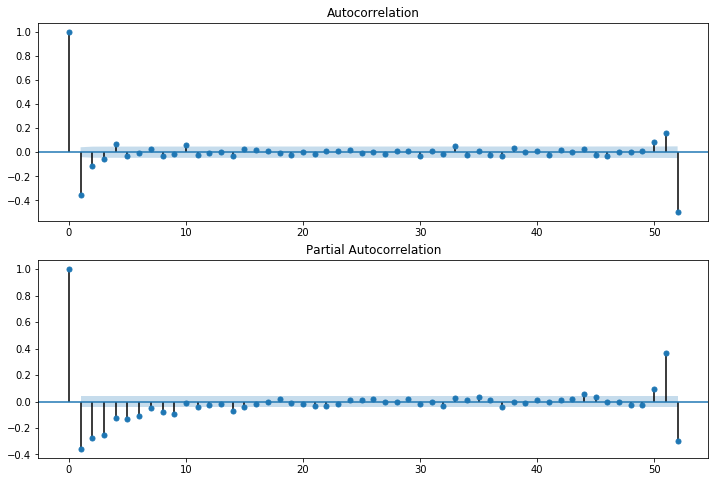

In [18]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(s_co2_fad.dropna(), lags=52, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(s_co2_fad.dropna(), lags=52, ax=ax2)

<br>
<h3>Seasonal Autoregressive Integrated Moving Average (SARIMA)</h3>
<p>Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.</p>
<h5>Trend Elements</h5>
<p>There are three trend elements that require configuration.</p>
<p>They are the same as the ARIMA model; specifically:</p>
<ul>
<li><strong>p</strong>: Trend autoregression order.</li>
<li><strong>d</strong>: Trend difference order.</li>
<li><strong>q</strong>: Trend moving average order.</li>
</ul>
<h5>Seasonal Elements</h5>
<p>There are four seasonal elements that are not part of ARIMA that must be configured; they are:</p>
<ul>
<li><strong>P</strong>: Seasonal autoregressive order.</li>
<li><strong>D</strong>: Seasonal difference order.</li>
<li><strong>Q</strong>: Seasonal moving average order.</li>
<li><strong>m</strong>: The number of time steps for a single seasonal period.</li>
</ul>

<br>

'p' is equal to the first lag where the PACF value is above the significance level, as we can see this is 1 for this timeseries. Likewise 'q' is equal to the first lag where the ACF value is above the significance level, 1 again. 'd' is equal to the difference model which makes the series stationary, the First Difference (above as well) model does the succesfully so we use 1 again.

We can see in the seasonal decomposition plot that the amplitude of the seasonal trend is constant, we can therefore assign the AR order, 'P', to 0. The seasonal difference order, 'D', is equal to the seasonal cycle lag at which the model is stationary, again as seen in the Annual Difference plot we can achieve this with a lag of 1 year. The seasonal average is also 1. The step size for a full seasonal cycle is 52 for each week.

If you want to learn how to do a grid search and have the program find the correct values check out <a href="https://youtu.be/D9y6dcy0xK8?t=1823">this video</a>

In [19]:
mod = sm.tsa.statespace.SARIMAX(s_co2, 
                                order=(1,1,1), 
                                seasonal_order=(0,1,1,52),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

C:\Users\ABour\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 2320
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -1300.888
Date:                            Sat, 06 Apr 2019   AIC                           2609.777
Time:                                    01:53:39   BIC                           2632.585
Sample:                                05-19-1974   HQIC                          2618.109
                                     - 10-28-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2306      0.026      8.895      0.000       0.180       0.281
ma.L1         -0.7854      0.018   

count    2320.000000
mean        0.057250
std         8.373126
min      -222.071340
25%        -0.267636
50%         0.006498
75%         0.278937
max       333.340000
dtype: float64


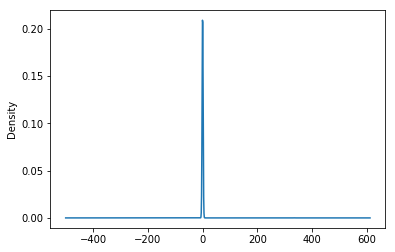

In [20]:
## Checking assumptions - 1) Errors are normally distributed

print(results.resid.describe())
results.resid.plot(kind='kde')

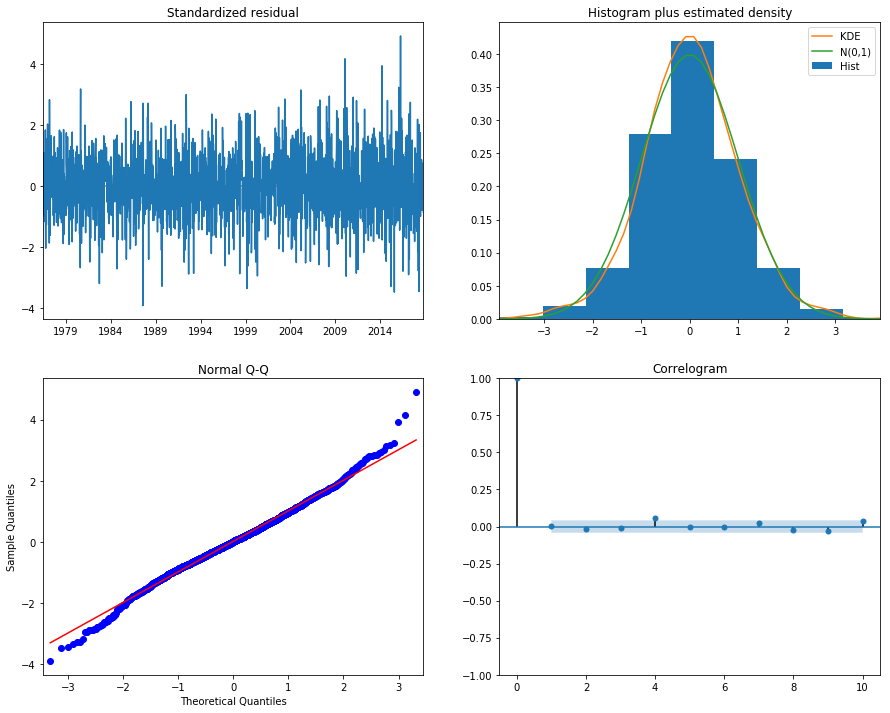

In [21]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Closeness of KDE and N plot in top right show the data is reasonably normalised

In [22]:
pred = results.get_prediction(start=2200, end=2320) ## 
pred_ci_1step = pred.conf_int()
pred_ci_1step.head()

,lower y,upper y
2016-07-17,403.765511,405.462074
2016-07-24,402.555671,404.252233
2016-07-31,402.251207,403.947769
2016-08-07,402.205347,403.901909
2016-08-14,401.660716,403.357278


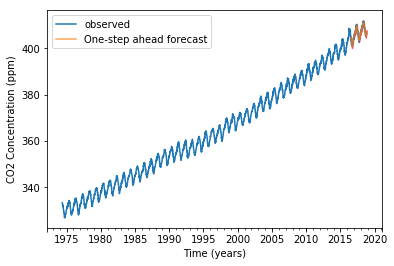

In [23]:
ax = s_co2.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci_1step.index,
                pred_ci_1step.iloc[:, 0],
                pred_ci_1step.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time (years)')
ax.set_ylabel('CO2 Concentration (ppm)')
plt.legend()

plt.show()

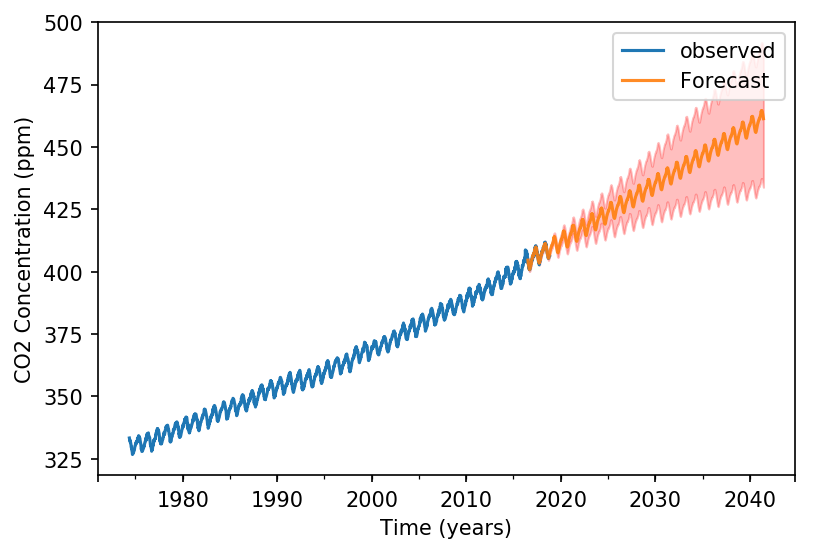

In [24]:
pred = results.get_prediction(start = 2200, end = 3500)
pred_ci_all_step = pred.conf_int()

fig = plt.figure(dpi=150)`
ax = s_co2.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9)

ax.fill_between(pred_ci_all_step.index,
                pred_ci_all_step.iloc[:, 0],
                pred_ci_all_step.iloc[:, 1], color='r', alpha=.25)

ax.set_xlabel('Time (years)')
ax.set_ylabel('CO2 Concentration (ppm)')
plt.legend()

plt.show()